In [5]:
from data_prep import prep_dataframe
import os
import pandas as pd

In [48]:
category = 'POL'
df1 = prep_dataframe('new_data/2020', category)
df2 = prep_dataframe('new_data/2021', category)

In [58]:
dfx = pd.concat([df1, df2],axis=0)
gps = dfx.groupby(['DeviceId']).size()
lengths = pd.DataFrame(gps,columns=['Len']).sort_values(by='Len', ascending = False)

In [59]:
lengths

,Len
DeviceId,
40005,11158
86253,10408
24207,10251
99057,10170
74022,9875
...,...
111033,218
73194,190
60135,110


In [39]:
for i in lengths.index:
    print(i)

40005
86253
24207
99057
74022
17136
69117
62046
97146
63129
43254
54147
57141
39177
65040
14142
36183
75105
55230
88164
44082
49242
67206
46248
42171
110205
98229
76188
78099
93069
87081
30195
108039
34017
32106
61218
91158
102051
59052
77016
89247
23124
105045
47076
18219
90075
41088
22041
92241
21213
52236
48159
53064
100140
104217
80010
72111
94152
58224
96063
25035
66123
27201
106128
35100
26118
38094
8154
51153
83004
95235
37011
15225
103134
121098
68034
13059
107211
111033
73194
60135
71028
50070


,Len
DeviceId,
40005,11158
86253,10408
24207,10251
99057,10170
74022,9875
...,...
111033,218
73194,190
60135,110


In [81]:

category = 'POL'
df1 = prep_dataframe('new_data/2020', category)
df2 = prep_dataframe('new_data/2021', category)

dfx = pd.concat([df1, df2])

In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel, BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset


from data_prep import prep_dataframe



gps = dfx.groupby(['DeviceId']).size()
lengths = pd.DataFrame(gps, columns=['Len']).sort_values(
        by='Len', ascending=False)

did = lengths.index[1]

df = dfx[dfx.DeviceId == did].sort_values(
        by=[ 'OrdinalDay', 'HourOfDay']
        ).reset_index(drop=True)

df = df[['ds', 'ActualPPM3', 'SolarIrradiance',
'humi', 'pop12', 'qpf', 'temp', 'wspd']]
df['ds'] = df['ds'].apply(lambda x: x.split(' ')[0])
cols = ['ActualPPM3', 'SolarIrradiance',
'humi', 'pop12', 'qpf', 'temp', 'wspd']
df[cols] = df[cols].apply(pd.to_numeric)
gps = df.groupby(['ds']).mean()


idx = pd.date_range('01-01-2021', '12-31-2022')
gps.index = pd.DatetimeIndex(gps.index)

gps = gps.reindex(idx, fill_value=np.NaN)
gps['time'] = pd.to_datetime(gps.index)
df_avg = gps.reset_index(drop=True)


    


In [95]:
df_avg

,ActualPPM3,SolarIrradiance,humi,pop12,qpf,temp,wspd,time
0,239.689283,5.707729,89.305400,3.500,0.0000,28.9490,2.38140,2021-01-01
1,532.981230,5.707729,79.548500,3.000,0.0000,27.5075,2.81875,2021-01-02
2,603.556947,5.707729,78.012167,42.875,0.0525,30.4325,3.20750,2021-01-03
3,567.441611,5.707729,82.476042,15.125,0.0025,34.3250,2.60000,2021-01-04
4,838.864318,5.707729,78.116708,85.500,0.0600,37.4525,4.27650,2021-01-05
...,...,...,...,...,...,...,...,...
725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-27
726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-28
727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-29
728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-30


In [98]:
df_avg_filled = df_avg.copy()
for cols in df_avg.columns:
    if cols == 'time':
        continue
    series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df_avg, "time", [cols]
    ),
    "auto")
    df_avg_filled[cols] = series_en.values()

<AxesSubplot:>

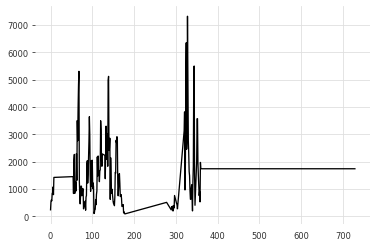

In [99]:
df_avg_filled['ActualPPM3'].plot()

In [102]:
def random_imputation(df, feature):

        number_missing = df[feature].isnull().sum()
        observed_values = df.loc[df[feature].notnull(), feature]
        df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)

        return df
def det_regression(df):

        #Random imp first:
        missing_columns = df.columns
        for feature in missing_columns:
            df[feature + '_imp'] = df[feature]
            df = random_imputation(df, feature)
        df_random=df.copy()


        deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])
        for feature in missing_columns:

            deter_data["Det" + feature] = df[feature + "_imp"]
            parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
            #Create a Linear Regression model to estimate the missing data

            X = df[parameters].values.tolist()
            y = df[feature + '_imp'].values.tolist()
            poly = PolynomialFeatures(degree=self.poly_degree )
            X_ = poly.fit_transform(X)

            predict_ = poly.fit_transform(df[parameters])[df[feature].isnull()]

            print(parameters)

            model = linear_model.LinearRegression()
            model.fit(X = X_, y = y)
        #     model.coef_[model.coef_<0.00001]=0
            #observe that I preserve the index of the missing data from the original dataframe
            deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(predict_)


        deter_data.columns=[x.split('Det')[1] for x in deter_data.columns]

        return  deter_data,df_random

In [101]:
df_fff = det_regression(df)

TypeError: det_regression() missing 1 required positional argument: 'df'